### Imports

In [2]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

In [3]:
import torch.nn.functional as F
import monai
import numpy as np
import TPTBox
import torch
from TPTBox import NII
from utils.brats_tools import get_central_slice, plot_slices
import utils.fastnumpyio.fastnumpyio as fnio
from data.bids_dataset import create_bids_path_list_of_dicts
import matplotlib.pyplot as plt

### Pipeline for transforming a raw nifti to a one-hot encoded torch tensor

In [4]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'

train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

In [5]:
# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

#### For Plotting

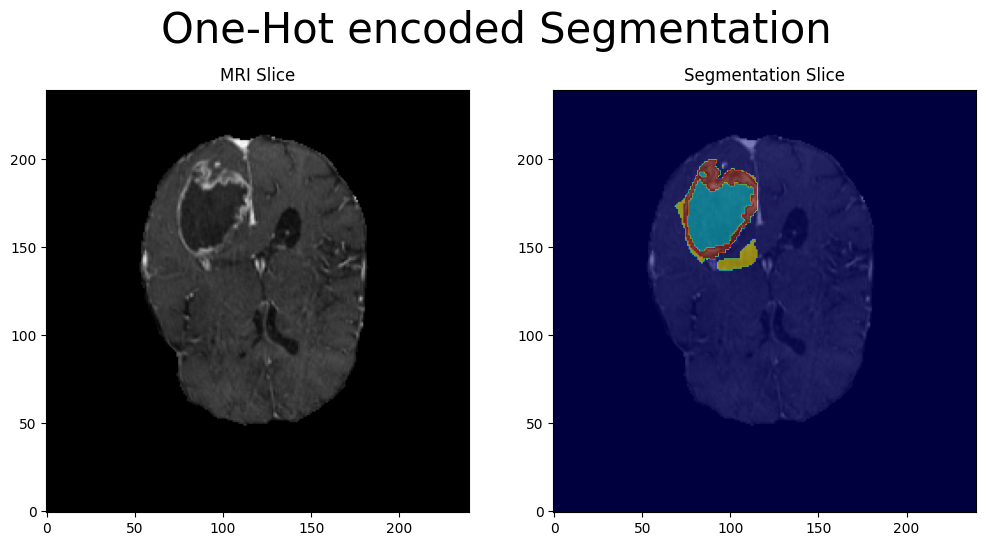

In [10]:
# 4. get slices
xy_slice = get_central_slice(img_tensor, axis = 2)
xy_oh_seg_slice = get_central_slice(oh_seg, axis = 2)

# 5. convert one-hot encoded slice to class map
xy_oh_seg_slice_class_map = torch.argmax(xy_oh_seg_slice, dim=0)

# 5. plot slices
plot_slices(xy_slice, xy_oh_seg_slice_class_map, omit_background=False, plt_title='One-Hot encoded Segmentation')

##### Plot XZ

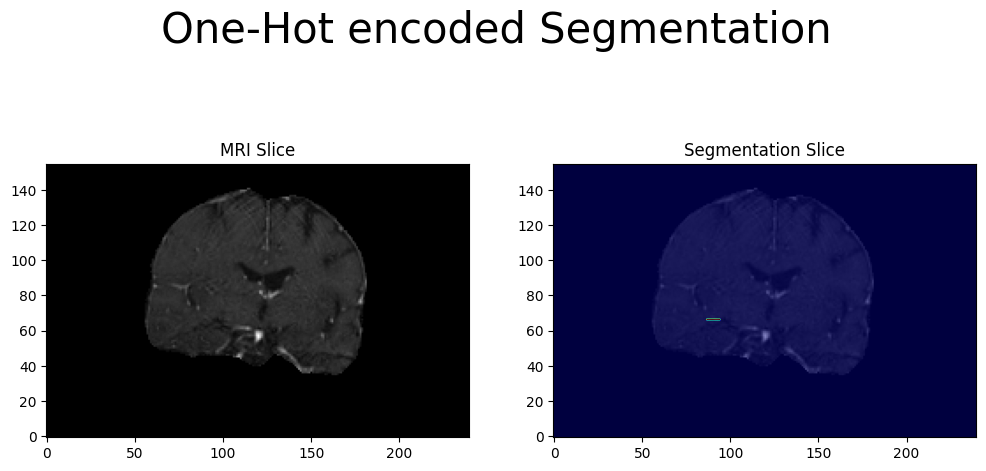

In [11]:
xz_slice = get_central_slice(img_tensor, axis = 1)
xz_oh_seg_slice = get_central_slice(oh_seg, axis = 1)

# 5. convert one-hot encoded slice to class map
xz_oh_seg_slice_class_map = torch.argmax(xz_oh_seg_slice, dim=0)

# 5. plot slices
plot_slices(xz_slice, xz_oh_seg_slice_class_map, omit_background=False, plt_title='One-Hot encoded Segmentation')

##### Plot YZ 

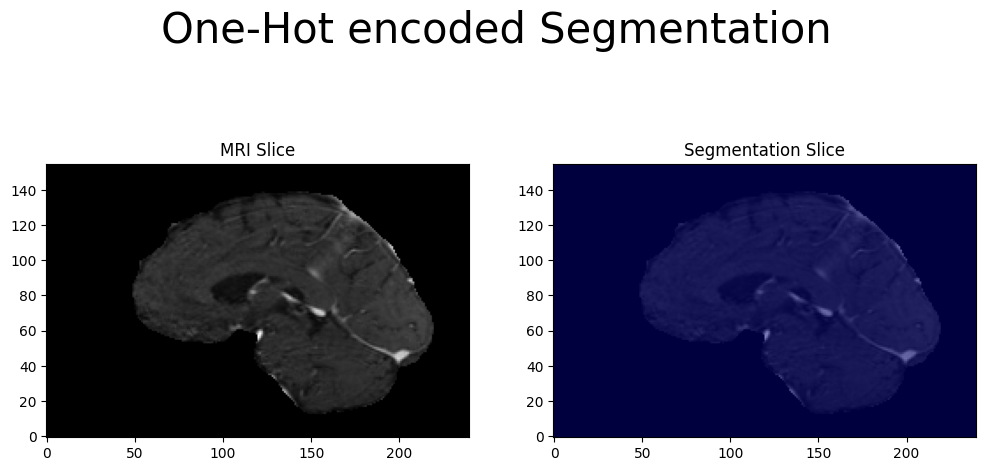

In [12]:
yz_img_slice = get_central_slice(img_tensor, axis = 0)
yz_oh_seg_slice = get_central_slice(oh_seg, axis = 0)

# 5. convert one-hot encoded slice to class map
yz_oh_seg_slice_class_map = torch.argmax(yz_oh_seg_slice, dim=0)

# 5. plot slices
plot_slices(yz_img_slice, yz_oh_seg_slice_class_map, omit_background=False, plt_title='One-Hot encoded Segmentation')

### For Comparison: same sample without one-hot

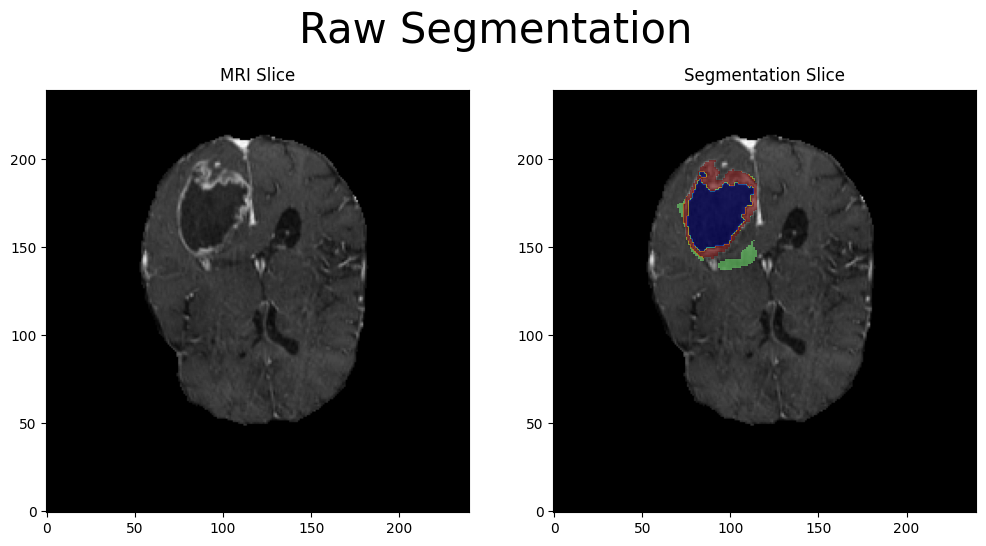

In [13]:
seg_slice = get_central_slice(seg_tensor, axis = 2)
plot_slices(xy_slice, seg_slice, omit_background=True, plt_title='Raw Segmentation')

#### Create a sample seg

In [9]:
import torch

# Define the dimensions
x, y, z = 20, 20 , 20  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius of the circle (let's assume a radius of 20)
radius = 5

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius] = 1

#One-hot encode the sample segmentation
oh_tensor = F.one_hot(circle_tensor, num_classes=2).permute(3, 0, 1, 2)

####################################
/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.s

##### Plotting

Text(0.5, 0.98, 'With One-Hot')

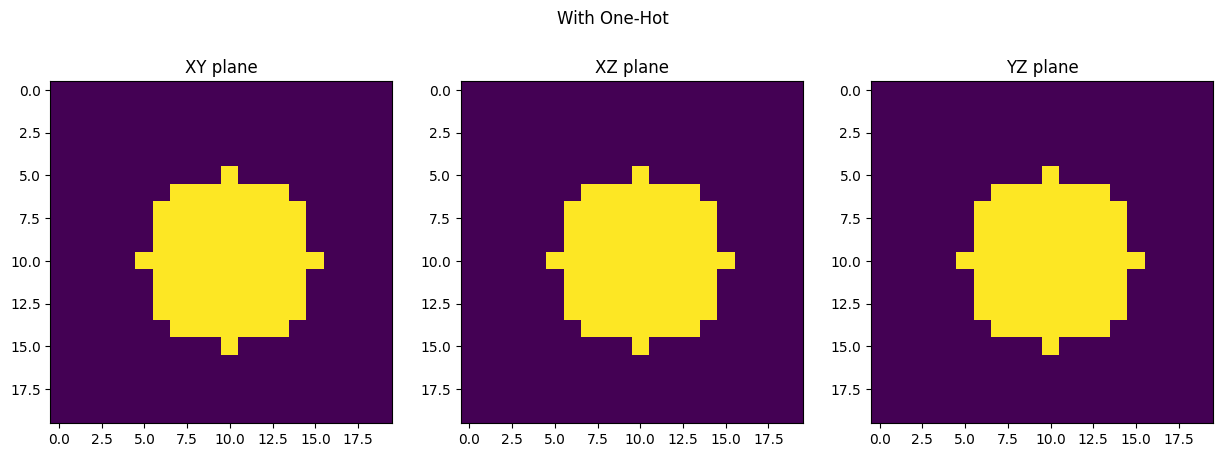

In [10]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)
xz_class_map = torch.argmax(xz_slice, dim=0)
yz_class_map = torch.argmax(yz_slice, dim=0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

Text(0.5, 0.98, 'Without One-Hot')

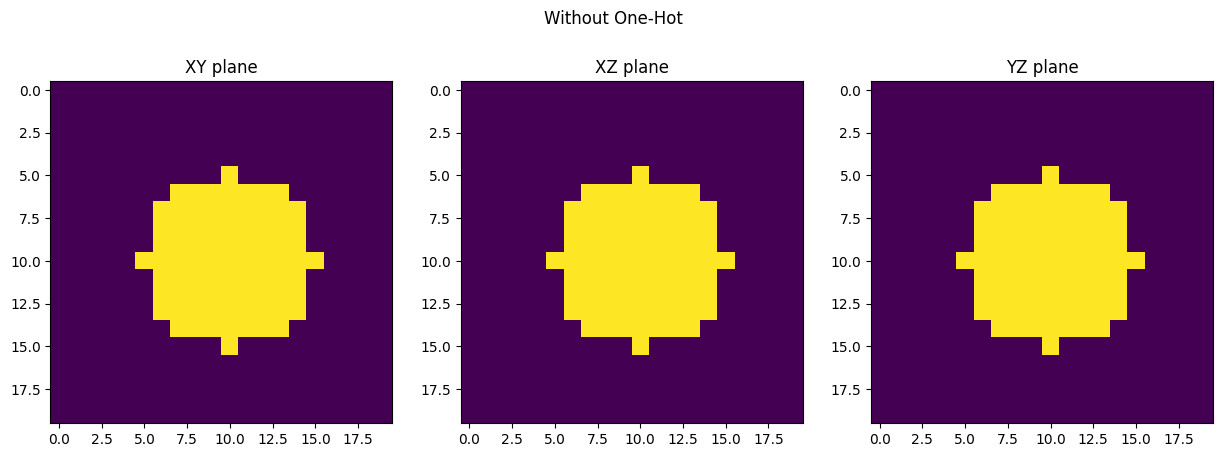

In [11]:
#Without one hot
# plot the one-hot encoded map
xy_slice = get_central_slice(circle_tensor, axis = 2)
xz_slice = get_central_slice(circle_tensor, axis = 1)
yz_slice = get_central_slice(circle_tensor, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')
#set overall title
plt.suptitle('Without One-Hot')

#### Try a Gaussian Filter without one-hot encoding

In [12]:
import scipy.ndimage

In [13]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_tensor = torch.empty_like(circle_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

#upscale the values of circle tensor
circle_tensor = circle_tensor * 1000

for x in range(circle_tensor.shape[0]):  # Loop through all dimensions
    filtered_tensor[x] = torch.tensor(scipy.ndimage.gaussian_filter(circle_tensor[x].numpy(), sigma=sigma))
for y in range(circle_tensor.shape[1]):  # Loop through all dimensions
    filtered_tensor[y] = torch.tensor(scipy.ndimage.gaussian_filter(circle_tensor[y].numpy(), sigma=sigma))
for z in range(circle_tensor.shape[2]):  # Loop through all dimensions
    filtered_tensor[z] = torch.tensor(scipy.ndimage.gaussian_filter(circle_tensor[z].numpy(), sigma=sigma))


print(filtered_tensor.shape)  # Should still be (x,y,z)
print(filtered_tensor)
print(f"np.unique(filtered_tensor): {np.unique(filtered_tensor)}")
print(f"np.unique(one_hot_tensor): {np.unique(circle_tensor)}")

torch.Size([20, 20, 20])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.

Text(0.5, 1.0, 'YZ plane')

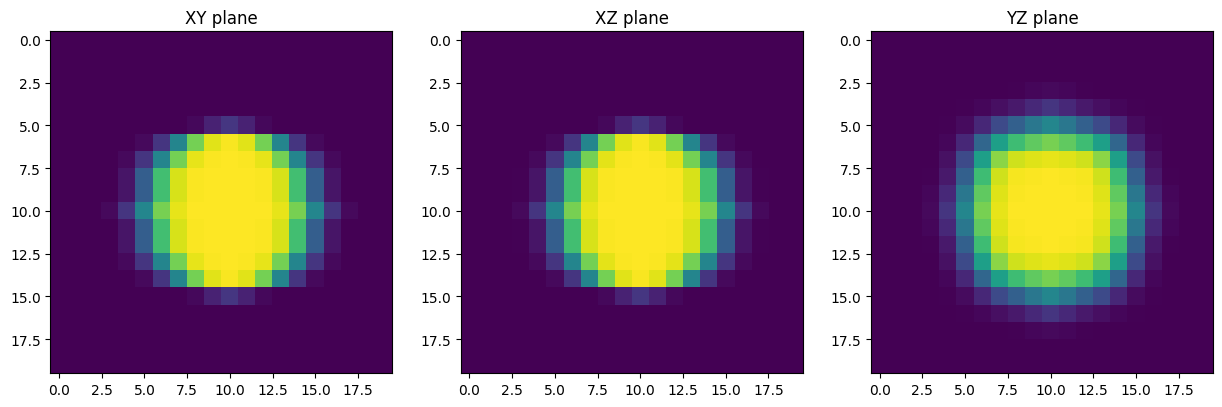

In [14]:
xy_slice = get_central_slice(filtered_tensor, axis = 2)
xz_slice = get_central_slice(filtered_tensor, axis = 1)
yz_slice = get_central_slice(filtered_tensor, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

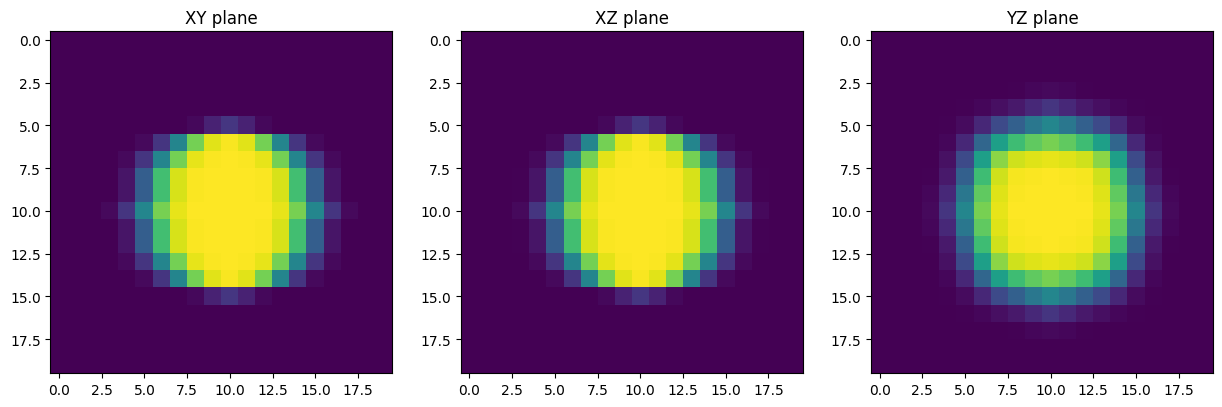

In [15]:
#Squash values back to 0 and 1
filtered_tensor = filtered_tensor / 1000
xy_slice = get_central_slice(filtered_tensor, axis = 2)
xz_slice = get_central_slice(filtered_tensor, axis = 1)
yz_slice = get_central_slice(filtered_tensor, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

#### Try a Gaussian Filter on one-hot encoded

##### Create and apply filter

In [16]:
import scipy.ndimage

In [17]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

#upscale the values of circle tensor
oh_tensor = oh_tensor * 1000

for i in range(oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_tensor[i].numpy(), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (2, x, y, z)
print(filtered_oh_tensor)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(one_hot_tensor): {np.unique(oh_tensor)}")

torch.Size([2, 20, 20, 20])
tensor([[[[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          ...,
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]],

         [[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          ...,
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.]],

         [[1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          [1000., 1000., 1000.,  ..., 1000., 1000., 1000.],
          ...,
          [1000., 1000.

##### Downsample the values again

In [18]:
filtered_oh_tensor = filtered_oh_tensor / 1000
print(f"filtered_oh_tensor[:,7,15,10]: {filtered_oh_tensor[:,7,15,10]}")

filtered_oh_tensor[:,7,15,10]: tensor([0.8410, 0.1570])


##### Plot slices channelwise, to visualize the "probablities' of each class

Text(0.5, 1.0, 'YZ plane')

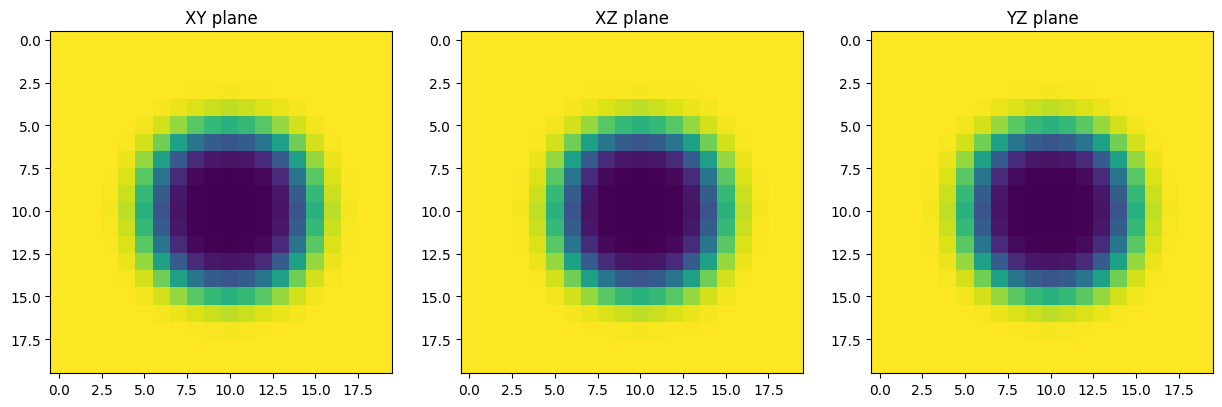

In [19]:
first_channel = filtered_oh_tensor[0]

xy_slice = get_central_slice(first_channel, axis = 2)
xz_slice = get_central_slice(first_channel, axis = 1)
yz_slice = get_central_slice(first_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

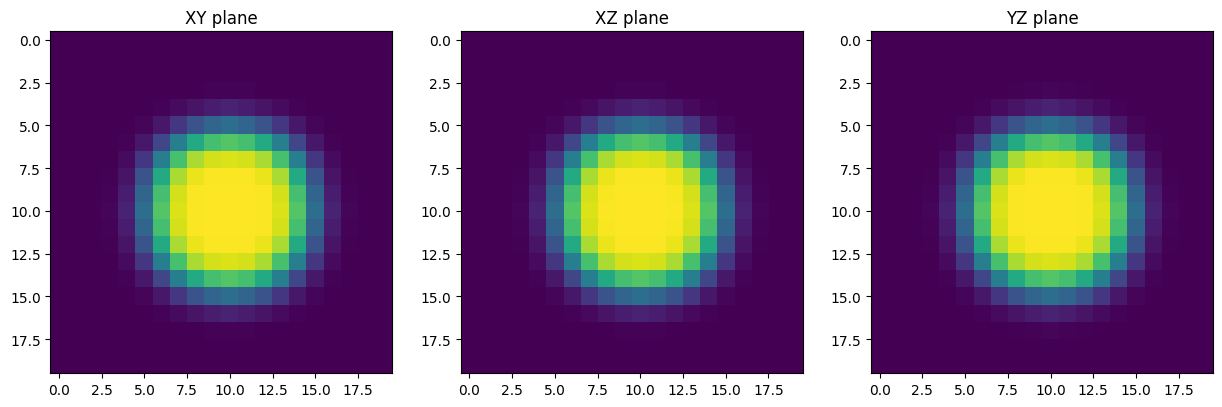

In [20]:
sec_channel = filtered_oh_tensor[1]

xy_slice = get_central_slice(sec_channel, axis = 2)
xz_slice = get_central_slice(sec_channel, axis = 1)
yz_slice = get_central_slice(sec_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

#### Create sample seg with 4 classes

In [21]:
import torch

# Define the dimensions
x, y, z = 100, 100 , 100  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius' of the circles (let's assume a radius of 20)
radius_c3 = 5
radius_c2 = 20
radius_c1 = 40

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius_c1] = 1
circle_tensor[distance <= radius_c2] = 2
circle_tensor[distance <= radius_c3] = 3

print(f"circle_tensor.shape: {circle_tensor.shape}")  # Should be (x,y,z)
print(f"np.unique(circle_tensor): {np.unique(circle_tensor)}")

#One-hot encode the sample segmentation
oh_tensor = F.one_hot(circle_tensor, num_classes=4).permute(3, 0, 1, 2)

print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

circle_tensor.shape: torch.Size([100, 100, 100])
np.unique(circle_tensor): [0 1 2 3]
oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]


##### Plot normal seg map

Text(0.5, 0.98, 'Without One-Hot')

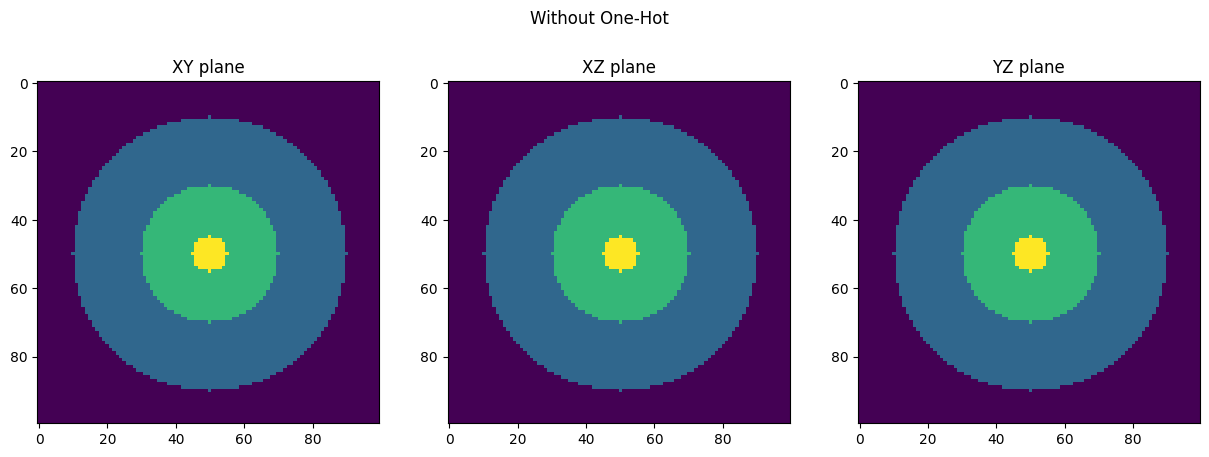

In [22]:
#Without one hot
# plot the one-hot encoded map
xy_slice = get_central_slice(circle_tensor, axis = 2)
xz_slice = get_central_slice(circle_tensor, axis = 1)
yz_slice = get_central_slice(circle_tensor, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')
#set overall title
plt.suptitle('Without One-Hot')

##### Plot one-hot encoded

Text(0.5, 0.98, 'With One-Hot')

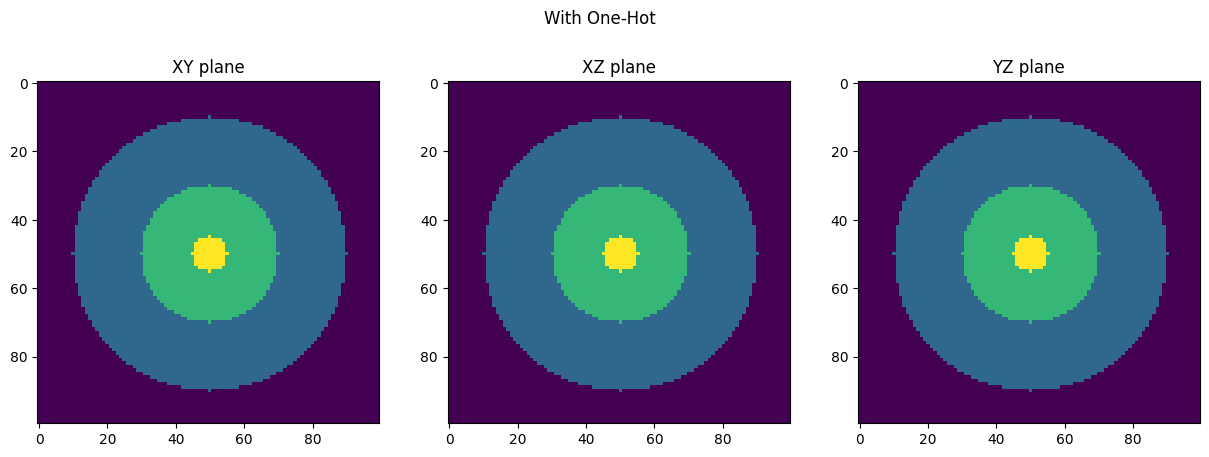

In [23]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)
xz_class_map = torch.argmax(xz_slice, dim=0)
yz_class_map = torch.argmax(yz_slice, dim=0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

#### Try Gaussian on multi-class one-hot

In [24]:
print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")
print(f"oh_tensor: {oh_tensor}")

oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]
oh_tensor: tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         ...,

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
    

In [25]:
import scipy.ndimage

In [26]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 5  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

#upsample the values of circle tensor
up_oh_tensor = oh_tensor * 1000

for i in range(up_oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(up_oh_tensor[i].numpy(), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

torch.Size([4, 100, 100, 100])
np.unique(filtered_tensor): [   0.    1.    2. ...  998.  999. 1000.]
np.unique(oh_tensor): [0 1]


##### Downsample values again


In [27]:
print(f"range of values before downsampling: {torch.min(filtered_oh_tensor)}, {torch.max(filtered_oh_tensor)}")

down_filtered_oh_tensor = filtered_oh_tensor / 1000
print(f"filtered_oh_tensor[:,7,15,10]: {down_filtered_oh_tensor[:,50,65,50]}")

print(f"range of values after downsampling: {torch.min(down_filtered_oh_tensor)}, {torch.max(down_filtered_oh_tensor)}")

range of values before downsampling: 0.0, 1000.0
filtered_oh_tensor[:,7,15,10]: tensor([0.0000, 0.2410, 0.7520, 0.0040])
range of values after downsampling: 0.0, 1.0


##### Plot slices channelwise, to visualize the "probablities' of each class

Text(0.5, 1.0, 'YZ plane')

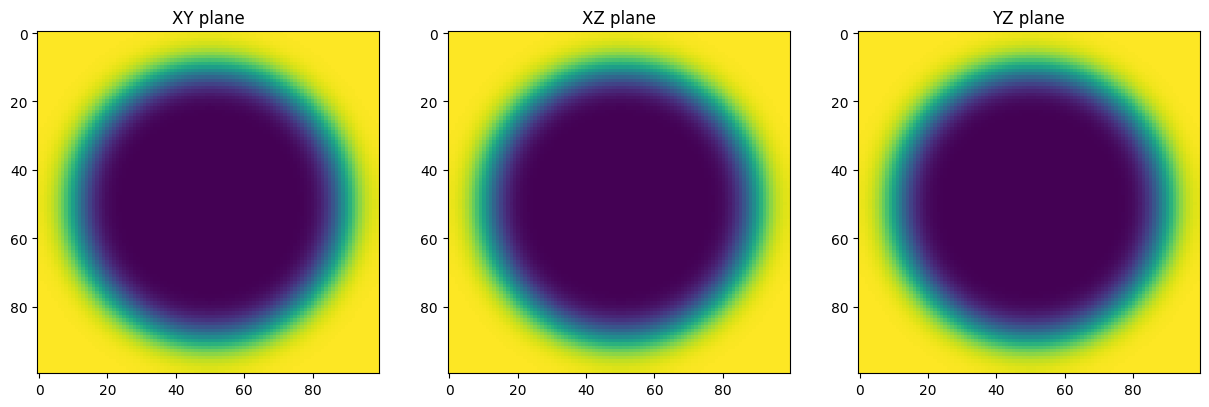

In [28]:
first_channel = down_filtered_oh_tensor[0]

xy_slice = get_central_slice(first_channel, axis = 2)
xz_slice = get_central_slice(first_channel, axis = 1)
yz_slice = get_central_slice(first_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

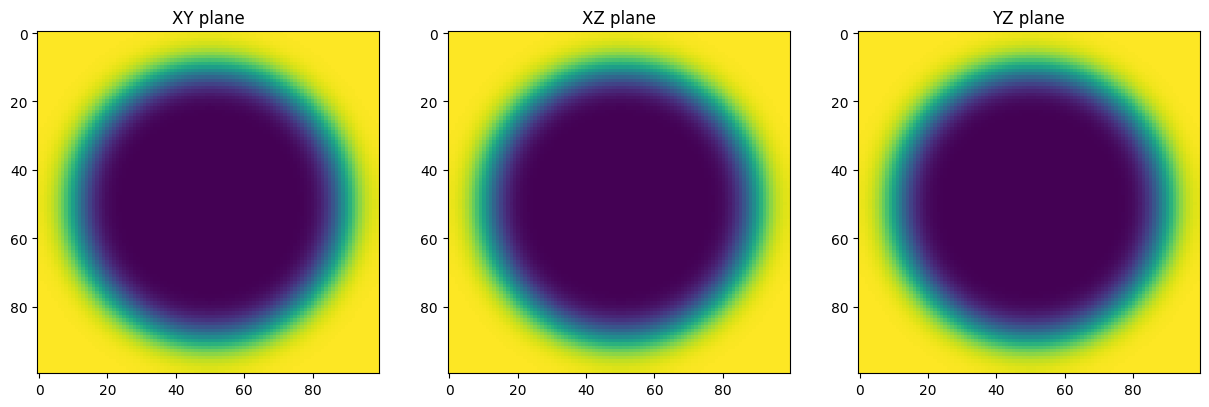

In [29]:
sec_channel = down_filtered_oh_tensor[0]

xy_slice = get_central_slice(sec_channel, axis = 2)
xz_slice = get_central_slice(sec_channel, axis = 1)
yz_slice = get_central_slice(sec_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

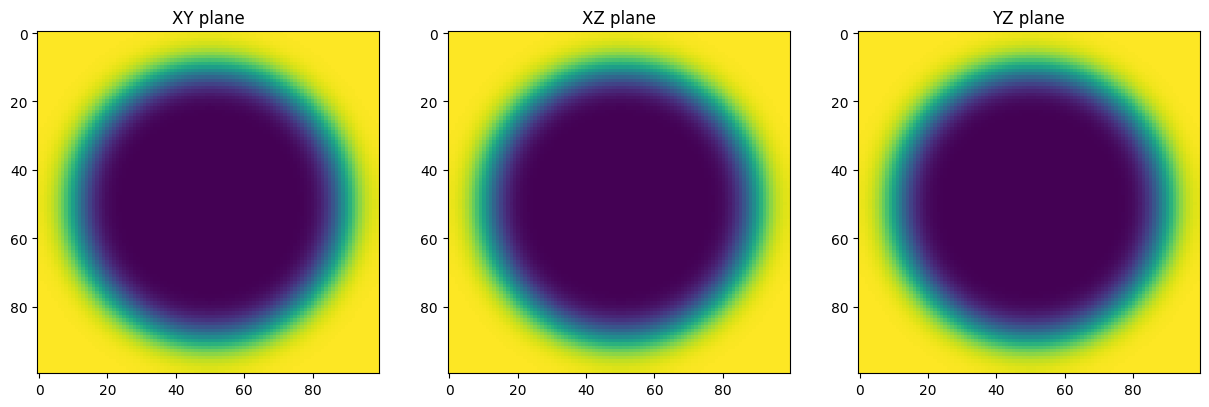

In [30]:
third_channel = down_filtered_oh_tensor[0]

xy_slice = get_central_slice(third_channel, axis = 2)
xz_slice = get_central_slice(third_channel, axis = 1)
yz_slice = get_central_slice(third_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

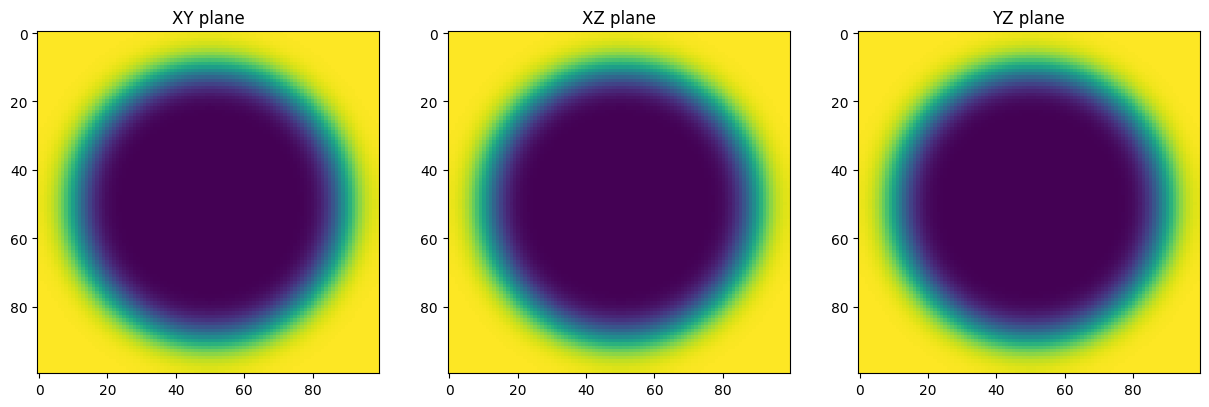

In [31]:
fourth_channel = down_filtered_oh_tensor[0]

xy_slice = get_central_slice(fourth_channel, axis = 2)
xz_slice = get_central_slice(fourth_channel, axis = 1)
yz_slice = get_central_slice(fourth_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

In [32]:
import scipy.ndimage

In [33]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value
up_factor = 10

# Apply Gaussian filter to each channel
filtered_oh_seg = torch.empty_like(oh_seg, dtype=torch.float32)  # Create an empty tensor to store the results

#upsample the values of circle tensor
up_oh_seg = oh_seg * up_factor

for i in range(up_oh_seg.shape[0]):  # Loop through each class channel
    filtered_oh_seg[i] = torch.tensor(scipy.ndimage.gaussian_filter(up_oh_seg[i].numpy(), sigma=sigma))


print(filtered_oh_seg.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_oh_seg): {np.unique(filtered_oh_seg)}")
print(f"np.unique(oh_seg): {np.unique(oh_seg)}")

torch.Size([4, 240, 240, 155])
np.unique(filtered_oh_seg): [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
np.unique(oh_seg): [0 1]


In [34]:
#Downsample filtered_oh_seg to get values between 0 and 1 again
down_filtered_oh_seg = filtered_oh_seg / up_factor
print(f"np.unique(down_filtered_oh_seg): {np.unique(down_filtered_oh_seg)}")

np.unique(down_filtered_oh_seg): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


#### Plotting for viz

In [35]:
xy_img_slice = get_central_slice(img_tensor, axis = 2)
xz_img_slice = get_central_slice(img_tensor, axis = 1)
yz_img_slice = get_central_slice(img_tensor, axis = 0)


##### Label 0 (Background)

Text(0.5, 1.0, 'YZ plane')

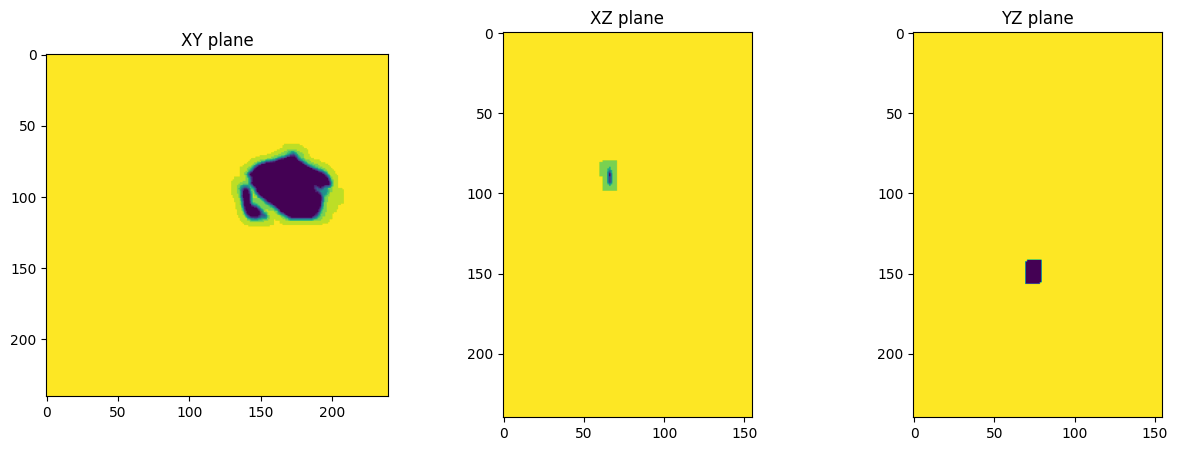

In [36]:
first_channel = down_filtered_oh_seg[0]

xy_seg_slice = get_central_slice(first_channel, axis = 2)
xz_seg_slice = get_central_slice(first_channel, axis = 1)
yz_seg_slice = get_central_slice(first_channel, axis = 0)

#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_seg_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_seg_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_seg_slice)
ax[2].set_title('YZ plane')

##### Overlaid filtered Segmentation on MRI slice

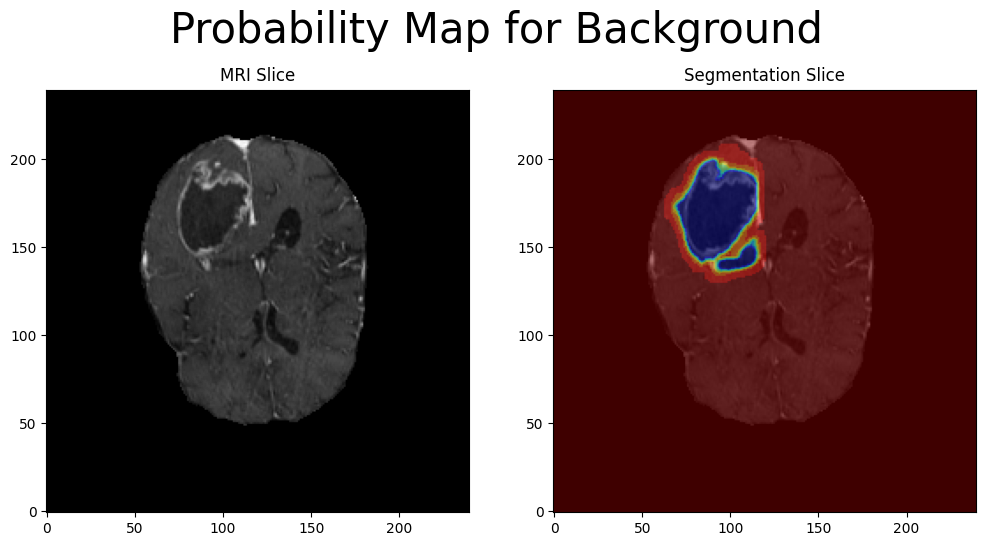

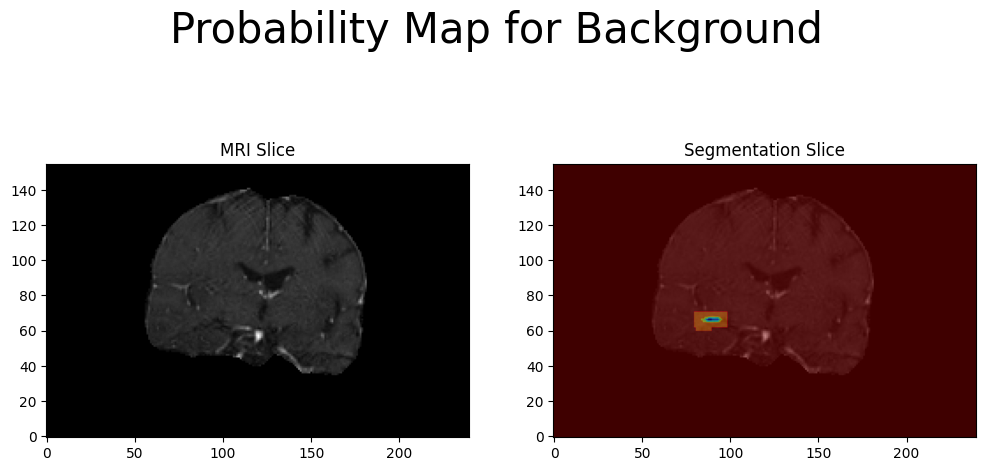

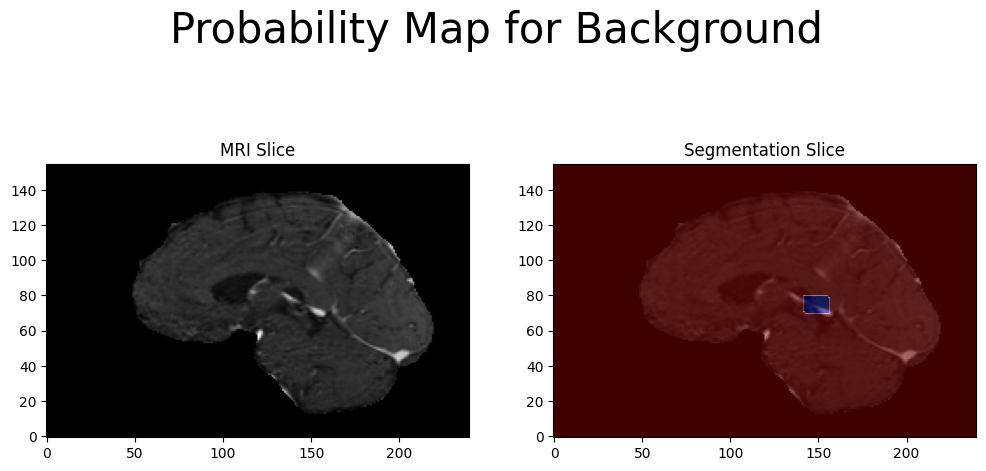

In [37]:
plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Background')

##### Label 1 (NCR (necrotic tumor core))

Text(0.5, 1.0, 'YZ plane')

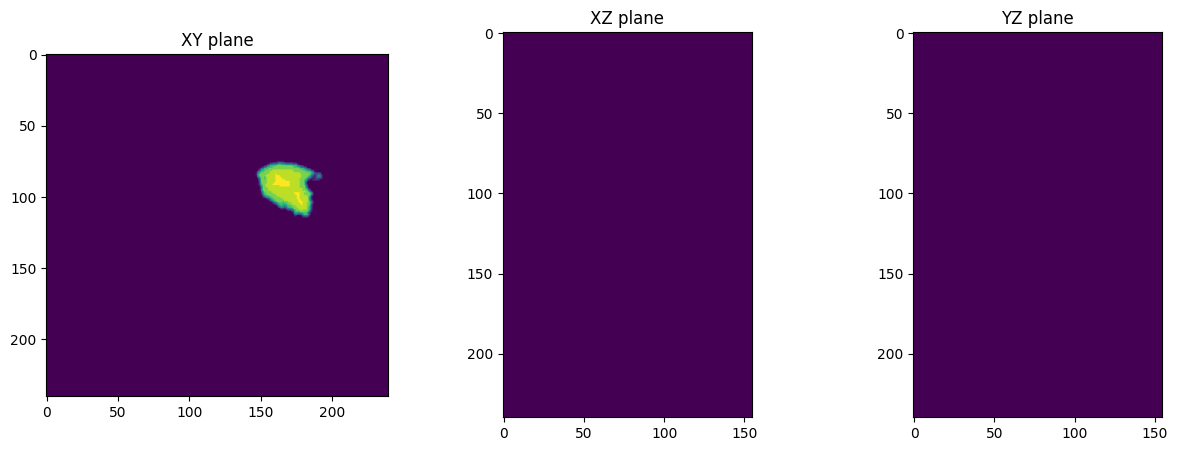

In [38]:
sec_channel = down_filtered_oh_seg[1]

xy_seg_slice = get_central_slice(sec_channel, axis = 2)
xz_seg_slice = get_central_slice(sec_channel, axis = 1)
yz_seg_slice = get_central_slice(sec_channel, axis = 0)

#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_seg_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_seg_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_seg_slice)
ax[2].set_title('YZ plane')

##### Overlaid Filtered Segmentation on MRI slice

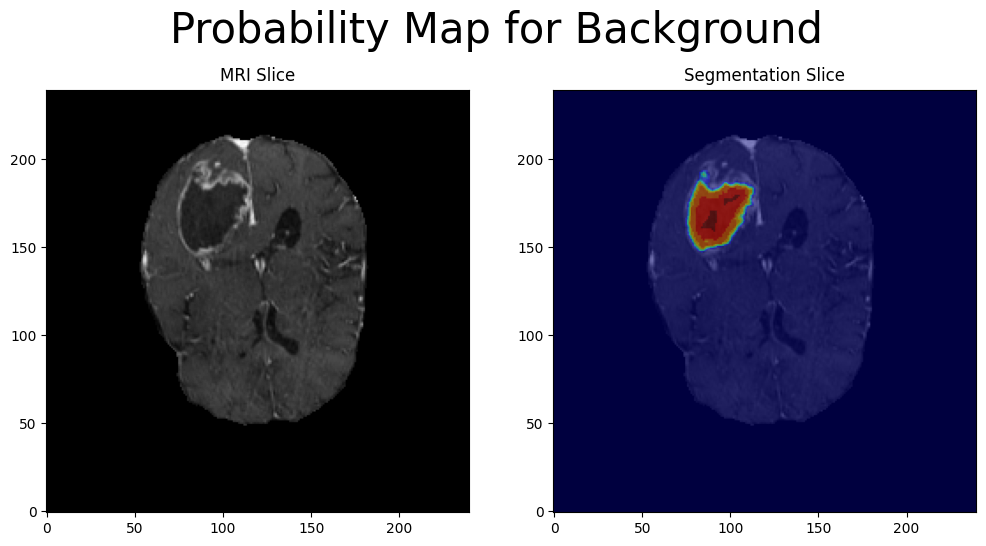

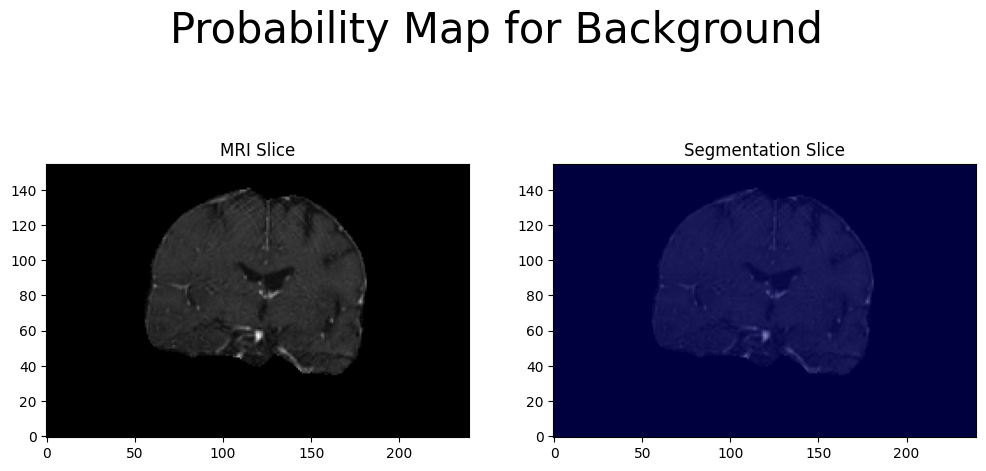

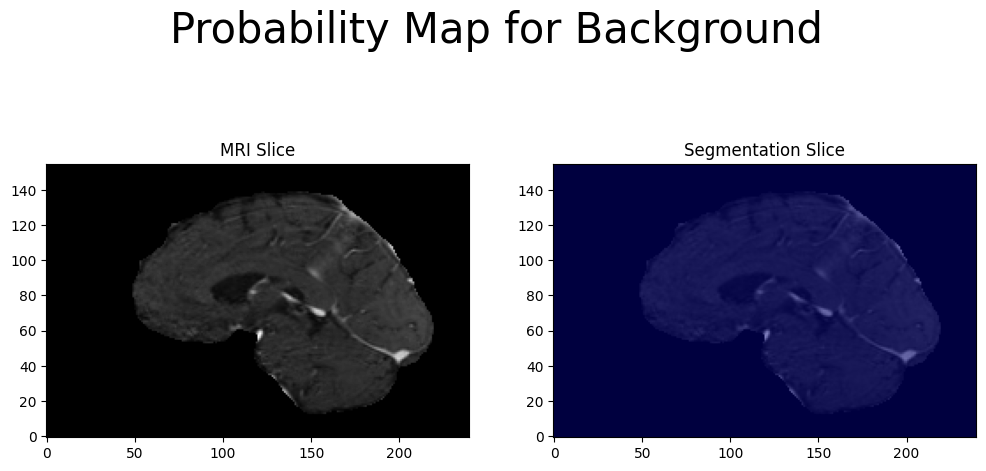

In [39]:
plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Background')

##### Label 2 ED (peritumoral edematous/invaded tissue)

Text(0.5, 1.0, 'YZ plane')

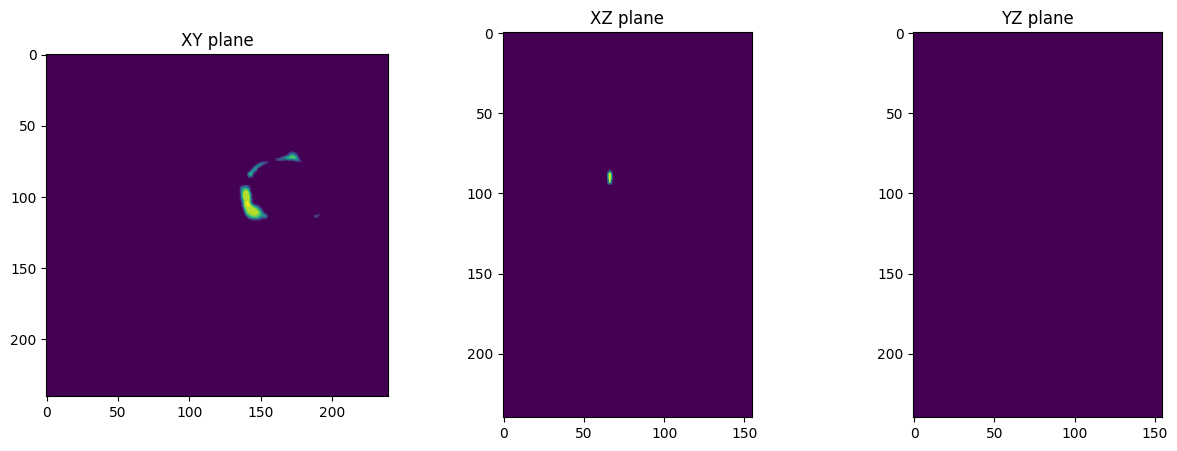

In [40]:
third_channel = down_filtered_oh_seg[2]

xy_seg_slice = get_central_slice(third_channel, axis = 2)
xz_seg_slice = get_central_slice(third_channel, axis = 1)
yz_seg_slice = get_central_slice(third_channel, axis = 0)

#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_seg_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_seg_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_seg_slice)
ax[2].set_title('YZ plane')

##### Overlaid Filtered Segmentation on MRI slice

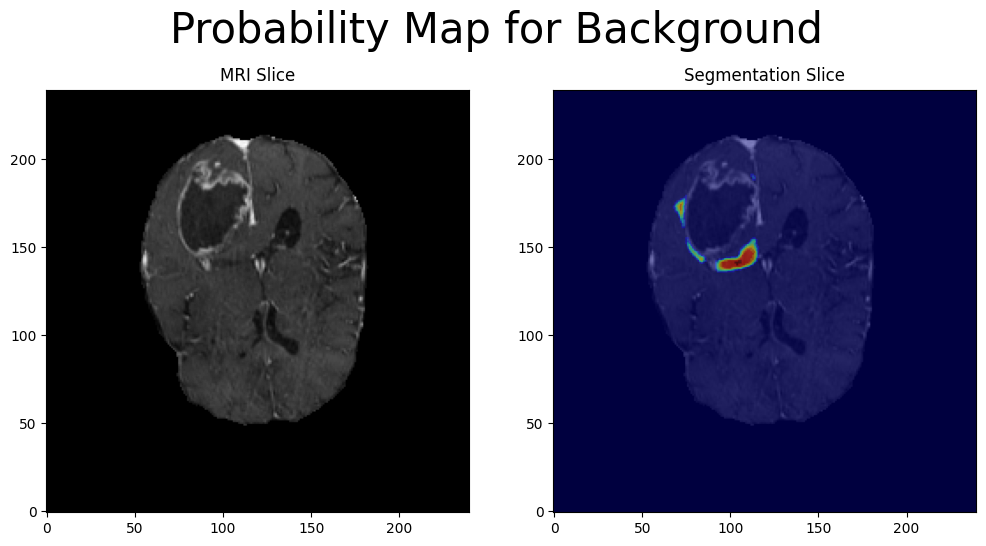

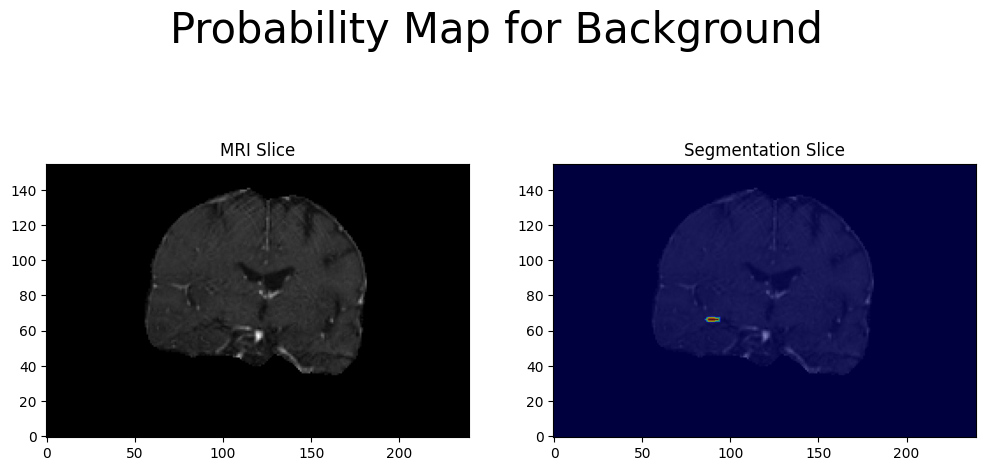

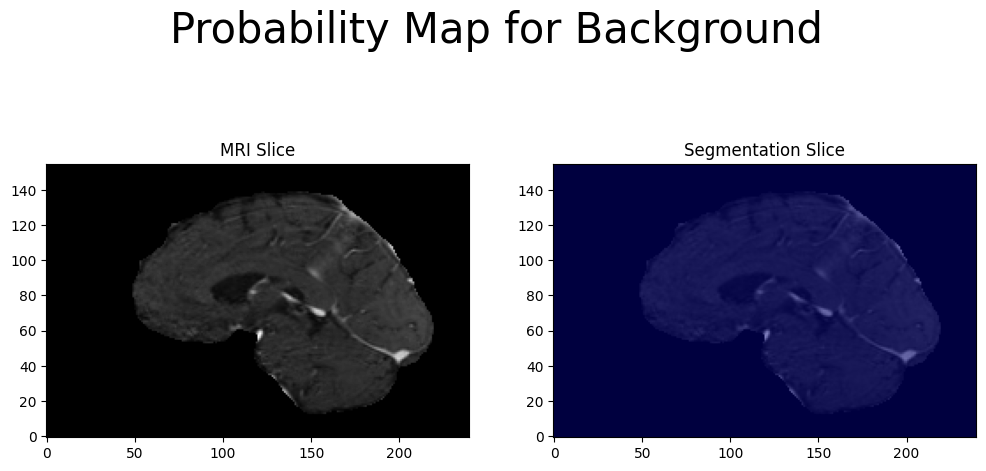

In [41]:
plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Background')

##### Label 3 ET (GD-enhancing tumor)

Text(0.5, 1.0, 'YZ plane')

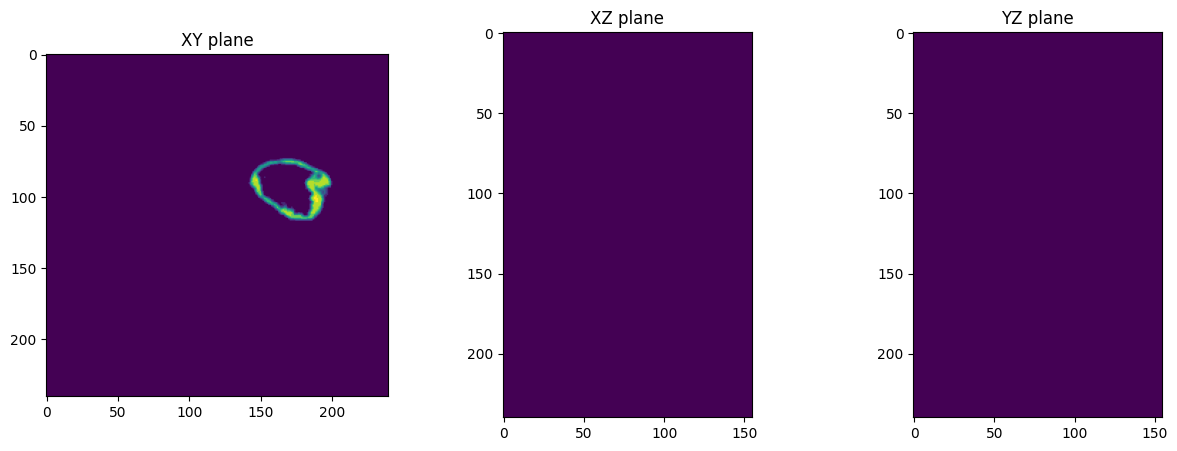

In [42]:
fourth_channel = down_filtered_oh_seg[3]

xy_seg_slice = get_central_slice(fourth_channel, axis = 2)
xz_seg_slice = get_central_slice(fourth_channel, axis = 1)
yz_seg_slice = get_central_slice(fourth_channel, axis = 0)

#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_seg_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_seg_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_seg_slice)
ax[2].set_title('YZ plane')

##### Overlaid Filtered Segmentation on MRI slice

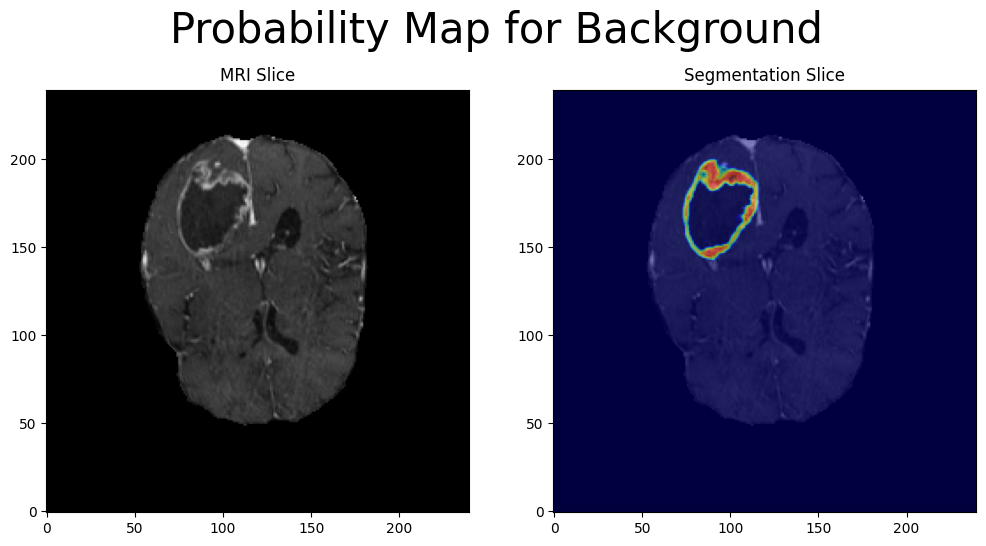

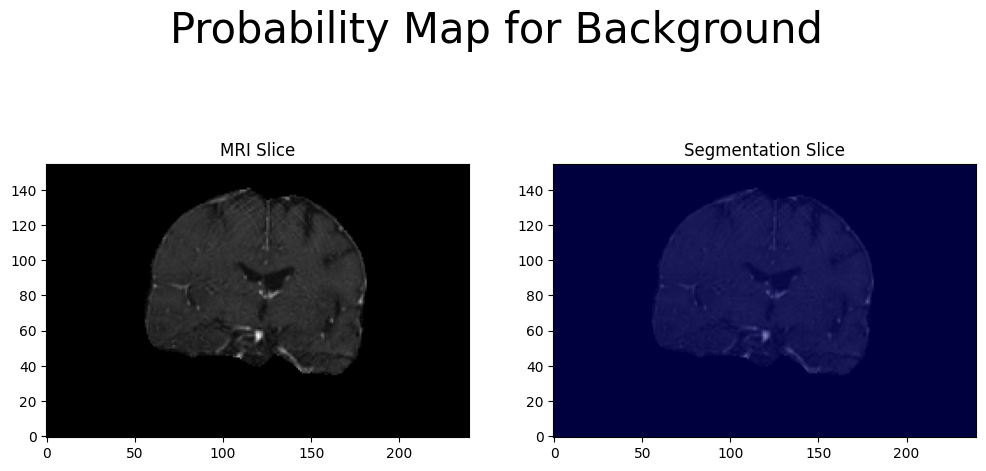

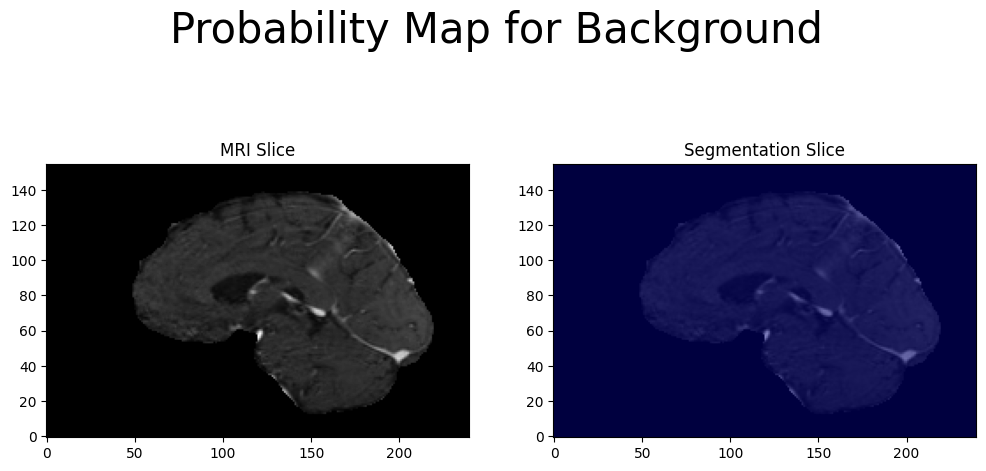

In [43]:
plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Background')
plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Background')